# ARIMA

The Autoregressive Integrated Moving Average Model, or ARIMA for short is a standard statistical model for time series forecast and analysis.
  
The authors Box and Jenkins also suggest a process for identifying, estimating, and checking models for a specific time series dataset. This process is now referred to as the Box-Jenkins Method.
  
We will be using concepts from this method such as Autocorrelation, Partial Autocorrelation and Akaike Information Criterion to tune the hyperparameters of the model as well as help evaluate the usefulness of this machine learning model.   
  
Although the dataset provides us with numerous varialbes, the profit or loss calculation of a stock is usually determined by the closing price, thus we will consider the closing price as the target variable. 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas import Series
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas import read_csv
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm

# Import Data

              Close
Date               
1984-09-07  0.42388
1984-09-10  0.42134
1984-09-11  0.42902
1984-09-12  0.41618
1984-09-13  0.43927


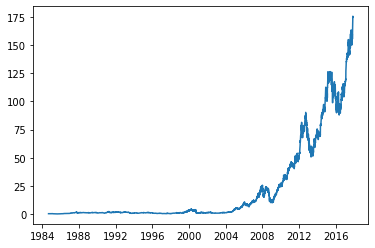

In [2]:
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
stock = 'aapl' 
path = 'data/Stocks/'
df = read_csv(path +'%s.us.txt'%stock, header=0, parse_dates=[0], index_col=0, date_parser=parser)
df.drop(columns=['OpenInt','Open','High','Low','Volume'], inplace = True)
print(df.head())
plt.plot(df['Close'])

# Setting parameters for train test split

In [3]:
train_test_split = 0.80

# Persistent Model

First, we establish a baseline by using a persistent model. This will act as a point of comparison for the ARIMA model.

In [4]:
values = pd.DataFrame(df['Close'])
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))

                t-1      t+1
Date                        
1984-09-07      NaN  0.42388
1984-09-10  0.42388  0.42134
1984-09-11  0.42134  0.42902
1984-09-12  0.42902  0.41618
1984-09-13  0.41618  0.43927


In [5]:
X = dataframe.values
train_size = int(len(X) * train_test_split)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [6]:
def model_persistence(x):
	return x

In [7]:
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

Test MSE: 1.952


# Splitting of data

In [8]:
# split into train and test sets
X = df.values
size = int(len(X) * train_test_split)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# Dickey-Fuller Test

The Dickey-Fuller test tests the null hypothesis that the data is non-stationary in an autoregressive time series model.   
For the ARIMA model to be used, the data has to be stationary and we achieve this by performing differencing. 

p-value > 0.05: Fail to reject the null hypothesis (H0), the data is non-stationary.  
p-value <= 0.05: Reject the null hypothesis (H0), the data is stationary.

In [9]:
X = pd.Series(train.flatten('F'))
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.782586
p-value: 1.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In this case, the p-value > 0.05 and thus clearly at least one order of differencing is needed to stationarize this series.  
We perform one order of differencing.

In [10]:
first_diff = X - X.shift(1)
first_diff = first_diff.dropna(inplace = False)
result = adfuller(first_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.815507
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


After one order of differencing, the p-value is extremely small. Thus this series is very likely to be stationary.

# Autocorrelation

We will be using the Box-Jenkins model to analyze the input parameters for Autoregressive integrated moving average (ARIMA) where the inputs are p, d, q.    
  
p : the order of the Auto Regressive (AR) term    
d : the minimum number of differencing needed to make the series stationar  
q : the order of the Moving Average (MA) term  


Firstly, we will be using the first order differenced values to try to find the AR term by inspecting the Partial Autocorrelation (PACF) plot.

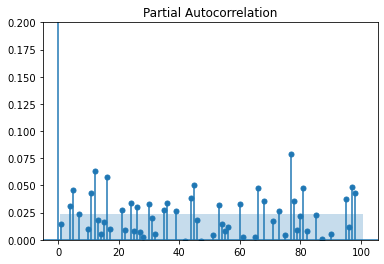

In [11]:
plot_pacf(first_diff, lags=100)
plt.ylim(0, 0.2)
plt.show()

Next, we try to find the MA term by insepcting the Autocorrelation (ACF) plot.

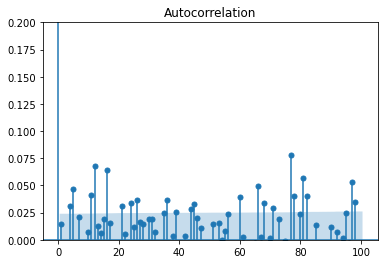

In [12]:
plot_acf(first_diff, lags = 100)
plt.ylim(0, 0.2)
plt.show()

As the long-term forecasts appear erratic or unstable, there may be a unit root in the AR or MA coefficients. Both the ACF and PACF plots show numerous significant spikes which do not decrease geometrically which also signifies the presence of white noise pattern. 
  
Therefore a more conclusive way to deteremine the model would be to make use of the pmdarima package auto ARIMA function which performs stepwise search to minimize Akaike Information Criterion value.

In [13]:
auto = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto.order)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1764.402, Time=0.68 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1763.767, Time=0.93 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1763.784, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1760.178, Time=0.64 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1761.850, Time=1.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 3.851 seconds
(0, 1, 0)


# ARIMA

Since we will be constantly updating our model everytime a new closing price for a stock comes out, we will be performing walk-forward validation on the generated ARIMA model.
At each step, the model predicts the next step value and updates the model with the actual value by using a expanding window.  

In [27]:
model = auto

def forecast_one_step():
    fc = model.predict(n_periods=1)
    return fc.tolist()[0]

predictions = []

for t in range(len(test)):
    fc = forecast_one_step()
    predictions.append(fc)
    print('predicted=%f, expected=%f' % (fc, test[t]))
    model.update(test[t])

predicted=174.690830, expected=43.436000
predicted=43.441731, expected=44.179000
predicted=44.184201, expected=45.019000
predicted=45.024307, expected=44.877000
predicted=44.882307, expected=44.945000
predicted=44.950311, expected=44.646000
predicted=44.651296, expected=44.631000
predicted=44.636287, expected=44.126000
predicted=44.131252, expected=43.695000
predicted=43.700206, expected=43.401000
predicted=43.406166, expected=43.291000
predicted=43.296141, expected=43.294000
predicted=43.299129, expected=42.908000
predicted=42.913099, expected=42.364000
predicted=42.369047, expected=42.568000
predicted=42.573037, expected=43.046000
predicted=43.051058, expected=42.570000
predicted=42.575042, expected=41.936000
predicted=41.940992, expected=42.498000
predicted=42.503003, expected=43.267000
predicted=43.272060, expected=43.849000
predicted=43.854127, expected=44.911000
predicted=44.916309, expected=45.208000
predicted=45.213321, expected=44.875000
predicted=44.880309, expected=44.842000

KeyboardInterrupt: 

Test RMSE: 1.396


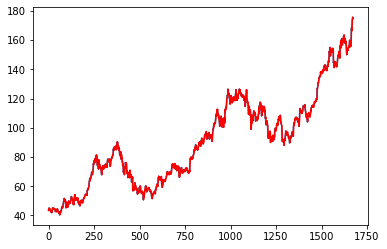

In [20]:
# evaluate predictions
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

As we can see above, the root mean square error of the ARIMA model is 1.396 while the error of the persistent model is 1.952 which means it has a higher accuracy. 

However when we zoom into the graph we can start to notice some trends which might show the ineffectiveness of the model.

<function matplotlib.pyplot.show(close=None, block=None)>

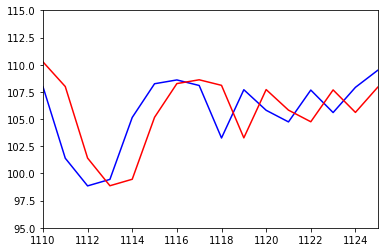

In [26]:
plt.plot(test, color = 'blue')
plt.plot(predictions, color='red')
plt.axis([1110,1125,95,115])
plt.show

The graph above looks extremely similar to the persistent model. Considering the equation of the autogressive model in the ARIMA model,   
  
X(t) = φ(1)X(t−1) + φ(2)X(t−2) + . . . + φ(p)X(t−p) + Z(t)  
  
We can guess that the coefficient of the t-1 step is extremely large as the correlation between t-1 and t steps are large. This is expected as for a stock market, the closing price for the previous day is correlated to the closing price of the current day.  
  
Thus although the mean squared error of the model is low, it is unable to accurately predict the day to day fluctuations of the stock price. 